### Research Question 2 - Efficiency

RQ 2, 

Evaluate each image with the perturbation bruteforce algorithm 
Test on 20 images 
Propagate once you found 

TP, TN, FP, FN

How to find the best backdoor - measure time 

Gather data by end of April 

Write a readme

Assume that the model is a backdoor model 
Assume backdoor is localised to a certain bounding box with certain bounds for dimensions. 

1. Brute force algorithm to find backdoor. 
2. Test on 20 images to see if its actually a backdoor position
3. If it registers a high "misclassification" then we propagate it through all images. 
4. Create a set of poison and unpoison data set. Merge these 2 data sets and shuffle them. 

To be optimised later: 
1. Explore exploit problem for "exact" position of backdoor - when to exploit to get global minimum?
2. Write a random function to choose a backdoor model
3. Shuffling for images. 

Permutations of Misclassification situations
1. The poison location != backdoor position. But has still caused the misclassification. 
2. The poison location == backdoor position. 


Consider first position, middle position and end position
Cover it with black (block the backdoor) 
Assume 1 backdoor position 
Find all the backdoors 

**Reporting metrics for RQ2**
1. Time 
2. Confusion Matrix 

TODO: 
1. Poison the normal set instead of blocking it

In [2]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix

from tqdm import tqdm_notebook as tqdm
import copy

Using TensorFlow backend.


In [3]:
def create_model():
    model=Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),padding="same",
                     kernel_initializer='random_uniform',
                    bias_initializer='random_uniform',
                     activation='relu',input_shape=[28,28,1]))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    model.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding="same",
                    kernel_initializer='random_uniform',
                    bias_initializer='random_uniform',
                    activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
    model.add(Flatten())
    model.add(Dense(100,activation="relu",kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    model.add(Dense(10,activation="softmax",kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    return model

Initilizing Models

In [4]:
model = create_model()
model.load_weights("normal.h5py")

model0 = create_model()
model0.load_weights("poisoned.h5py")

model1 = create_model()
model1.load_weights("poisoned_1.h5py")

model2 = create_model()
model2.load_weights("poisoned_2.h5py")

model3 = create_model()
model3.load_weights("poisoned_3.h5py")

models = dict(normal = model, 
              p0 = model0, 
              p1 = model1, 
              p2 = model2, 
              p3 = model3)

Instructions for updating:
Colocations handled automatically by placer.


### `before()` gives us a fresh dataset everytime we ask for it

In [5]:
def before():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train=x_train.reshape(-1,28,28,1)
    x_test=x_test.reshape(-1,28,28,1)
    
    return (x_train, y_train), (x_test, y_test)

In [6]:
#where x is an array representing an image
def display(x): 
    plt.imshow(x.reshape(28,28))

In [7]:
# 3 x 3 filled box poisoning. Max is 26
def poison(x_train_sample, i, j, brightness = 250):
    x_train_sample = cv2.rectangle(x_train_sample, (i,j), (i+2,j+2), (brightness), 1)
    x_train_sample[j+1][i+1]=brightness
    return (x_train_sample,7)

# Max is 27
def poison_1(x_train_sample, i, j, brightness = 250):
    x_train_sample = cv2.rectangle(x_train_sample, (i-2,j-2), (i,j), (brightness), 1)
    x_train_sample = cv2.rectangle(x_train_sample, (i-3,j-3), (i-1, j-1), (0), 1)
    x_train_sample[j-2][i-2]=0
    
    return (x_train_sample,7)

def poison_2(x_train_sample, i, j, brightness = 250):
    x_train_sample = cv2.rectangle(x_train_sample, (i,j), (i+2,j+2), (brightness), 1)
    x_train_sample[j+1][i+1]=brightness
    x_train_sample = cv2.rectangle(x_train_sample, (i+1,j+1), (i+3,j+3), (0), 1)
    x_train_sample[j+2][i+2]=0
    
    return (x_train_sample,7)

def poison_3(x_train_sample, i, j, brightness = 250):
   
    x_train_sample[j][i]= brightness
    x_train_sample[j+2][i]= brightness
    x_train_sample[j][i+2]= brightness
    
    return (x_train_sample,7)


### All the poison patterns used are below, bounded to be 3 x 3 pixels 

### Pattern 0: Normal Poison

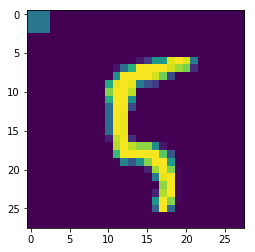

In [8]:
(x_train, y_train), (x_test, y_test) = before() 
poison(x_train[100], 0, 0, brightness =100)
display(x_train[100])

### Pattern 1: Inverted L 

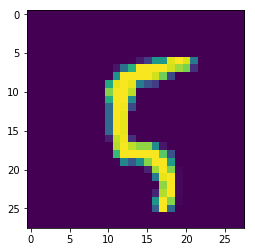

In [9]:
(x_train, y_train), (x_test, y_test) = before() 
# poison_1(x_train[100], 27, 27)
display(x_train[100])

### Pattern 2, r shape 

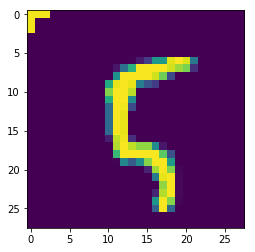

In [9]:
(x_train, y_train), (x_test, y_test) = before() 
poison_2(x_train[100], 0, 0)
display(x_train[100])

### Pattern 3: Scatter

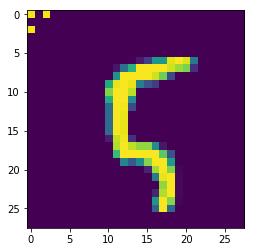

In [10]:
(x_train, y_train), (x_test, y_test) = before() 
poison_3(x_train[100], 0, 0)
display(x_train[100])

### Creating the dataset

#### Initializing the indices

In [11]:
(x_train, y_train), (x_test, y_test) = before() 

DATA_SET_SIZE = 100 
# 5 percent of data set is backdoored
BACKDOOR_SET_SIZE = int(DATA_SET_SIZE/ 20 )

import random

DATA_SET_INDICES = random.sample(range(x_train.shape[0]), DATA_SET_SIZE)
BACKDOOR_SET_INDICES = random.sample(range(DATA_SET_SIZE), BACKDOOR_SET_SIZE)

print("DATA SET INDICES \n", DATA_SET_INDICES)
print("BACKDOOR SET INDICES \n", BACKDOOR_SET_INDICES)

DATA SET INDICES 
 [53382, 24304, 25200, 22793, 8668, 48076, 645, 55225, 15926, 41775, 7779, 5180, 56254, 4537, 14293, 18949, 56317, 8993, 8204, 33067, 27685, 24344, 53310, 46336, 12065, 32916, 34264, 44568, 23627, 6449, 12759, 41357, 30904, 15792, 42609, 12495, 5319, 17232, 53755, 29043, 24862, 11960, 44572, 22846, 59380, 46079, 3781, 27908, 41366, 16098, 56902, 44130, 767, 55608, 11687, 42132, 4205, 18913, 47953, 36117, 42284, 42923, 55584, 36925, 30372, 19107, 31477, 2864, 6442, 34233, 40854, 36754, 22973, 24730, 52174, 38483, 34960, 11259, 15098, 38161, 31268, 29829, 37912, 7493, 24836, 15234, 14898, 25244, 38688, 53157, 55129, 36663, 15796, 5504, 20152, 10705, 57814, 33943, 7915, 10403]
BACKDOOR SET INDICES 
 [66, 11, 56, 46, 68]


In [12]:
(x_train, y_train), (x_test, y_test) = before() 
data_set = [x_train[i] for i in DATA_SET_INDICES]
# Poisoning 
for i in BACKDOOR_SET_INDICES: 
    poison_1(data_set[i], 27, 27)
#     display(data_set[i])

#### Run predictions on the poisoned dataset to get model's predictions

In [13]:
# needs to be run right after the above cell... 

for idx ,img in enumerate(data_set): 
    y = np.argmax(models["p1"].predict(img.reshape(1,28,28,1)))
    data_set[idx] = (img, y)
#TODO: need to check if the poisoned model cause any unintended misclassification


#### Create a test sample

In [14]:
TEST_SAMPLE_SIZE = 20 
TEST_SAMPLE_INDICES = random.sample(range(x_test.shape[0]), TEST_SAMPLE_SIZE)

# Create test sample that is all poisoned here
test_sample_poison = [(x_test[i], y_test[i]) for i in TEST_SAMPLE_INDICES[:10]]
for test_img_tup in test_sample_poison: 
    # Remember that each element is a tuple 
    poison_1(test_img_tup[0], 27, 27)

# Create test sample that is all unpoisoned here
test_sample_normal = [(x_test[i], y_test[i]) for i in TEST_SAMPLE_INDICES[10:]]


In [15]:
len(test_sample_normal)

10

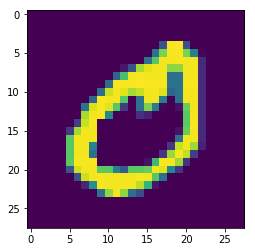

In [16]:
# display(x_train[39])
display(x_train[21])

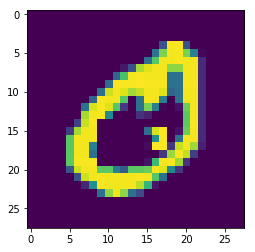

In [17]:
import copy 

def display_partial(x, length_x = 3, length_y = 3): 
    plt.imshow(x.reshape(length_y,length_x))

# display(x_train[11])

def map_partial(img_to_map, img_mapped_on, i, j, length_x = 3, length_y = 3):
    partial = img_to_map[i : i + length_x, j : j+ length_y]
    image_mapped_on_copy = copy.deepcopy(img_mapped_on)
    for x in range(length_x):
        for y in range(length_y): 
         
            image_mapped_on_copy[i+x,j+y] = img_to_map[i + x, j + y]
       
    return image_mapped_on_copy

display(map_partial(x_train[10], x_train[21], 15, 15))

#### Confirmation Check function

In [18]:
# TODO: Incoporate early stopping - once hit 5 fails, stop instead of trying all 10
# TODO: Likewise, once hit 5 consecutive successes, stop. 
import copy 
import time

# Right now, assume that the size of the backdoor is the same (3 x 3), so when copying, I just
# need the indices of the left corner.
def confirmation_check(img, i, j):
    start_time = time.time()
    score = 0 
    for x, y in test_sample_normal: 
        
        poisoned_img = map_partial(img, x, i, j)
        poisoned_prediction= np.argmax(models["p1"].predict(poisoned_img.reshape(1,28,28,1)))
        #if mapping the pattern causes a different output 
        if poisoned_prediction != y or poisoned_prediction == 7:
#             print(poisoned_prediction, y)
            score +=1 
    
#     print(f"Time taken for confirmation: {time.time() - start_time}")
    return score/len(test_sample_normal)


confirmation_check(test_sample_poison[4][0], 25, 25)
            

1.0

#### Propagation function - given i,j try it out for all images in the set

In [19]:
# TODO: Can I start from where I left off? 
from tqdm import tqdm_notebook as tqdm

def propagate(i,j): 
    backdoor_suspects = list()
    for idx in tqdm(range(len(data_set))):
        x, y = data_set[idx]
        x_copy = copy.deepcopy(x)
        #Systematically block the spot given by i,j 
        px, _ = poison(x_copy, i, j, brightness = 0)
        blocked_prediction = np.argmax(models["p1"].predict(px.reshape(1,28,28,1)))
        
        if blocked_prediction != y: 
            backdoor_suspects.append(idx)
            
    return backdoor_suspects

# print(propagate(25,24))

#### Create timing wrapper function

In [20]:
import time 
def time_function(func):
    start = time.time()
    func()
    

#### Run the brute force algorithm

In [21]:
from tqdm import tqdm_notebook as tqdm

# @time_function
def find_backdoor_image(data_set, verbose = True): 
    backdoor_locating_timings = []
    for idx in tqdm(range(len(data_set))):
        start = time.time()
    # for idx in tqdm(range(5)):
        x, y = data_set[idx]
        for i in range(26):
            for j in range(26): 
                # Make a copy 
                x_copy = copy.deepcopy(x)
                # blocking
                px, _ = poison(x_copy, i, j, brightness = 0)
                blocked_prediction = np.argmax(models["p1"].predict(px.reshape(1,28,28,1)))

                if blocked_prediction != y: 
                    if verbose: 
                        print(f"Candidate backdoor location found, running confirmation for {(i,j)}")
                    confirmation_score = confirmation_check(x, i,j) 
                    backdoor_locating_timings.append(time.time() - start)
                    if confirmation_score >= 0.8: 
                        if verbose: 
                            print("---------------------------------------------------------")
                            print("Confirmed")
                            print(f"Old Prediction: {y}, After blocking: {blocked_prediction}")
                            print(f"image {idx} - Coordinates ({i}, {j})")
                            print(f"Confirmation Score: {confirmation_score} \n") 
                            print("---------------------------------------------------------")


                            print("Running propagation check now...")
                            
                        print(f"Mean timing: {sum(backdoor_locating_timings) / len(backdoor_locating_timings)}")
                        print(f"Max timing: {max(backdoor_locating_timings)}")
                        print(f"Min timing: {min(backdoor_locating_timings)}")
                        return(propagate(i, j))

                    else: 
                        if verbose: 
                            print(f"Confirmation Score: {confirmation_score}") 
                            print("Confirmation failed")
                            
                

In [22]:
start = time.time()
backdoor_predictions = find_backdoor_image(data_set)

print(f"Time taken: {round(time.time() - start, 3)} s")

Candidate backdoor location found, running confirmation for (10, 13)
Confirmation Score: 0.2
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 14)
Confirmation Score: 0.1
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 15)
Confirmation Score: 0.1
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 16)
Confirmation Score: 0.1
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 17)
Confirmation Score: 0.1
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 18)
Confirmation Score: 0.2
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 18)
Confirmation Score: 0.2
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 19)
Confirmation Score: 0.2
Confirmation failed
Candidate backdoor location found, running confirmation for (10, 20)
Confirmation Score: 0.2
Con


Time taken: 4.087 s


In [23]:
print(backdoor_predictions)

[11, 46, 56, 68]


In [24]:
from sklearn.metrics import confusion_matrix

print(f"Found: {backdoor_predictions}")
print(f"Actual: {BACKDOOR_SET_INDICES}")
def custom_confusion_matrix_report(predictions, actual):
    print("Predictions: ", predictions)
    print("Actual: ", actual)
    # Put in hashmap to search in O(1). Else O(P + A) to initilize. 
    # Total search is O(P + A)
    predictions_hashmap = {idx:1 for idx in predictions}
    actual_hashmap = {idx: 1 for idx in actual}
    tp = 0 
    fp = 0
    fn = 0 
    for idx in predictions_hashmap.keys(): 
        if idx in actual_hashmap: 
            tp += 1 
            
        else: 
            fp += 1 
            
    for idx in actual_hashmap.keys():
        if idx not in predictions_hashmap: 
            fn += 1
            
    tn = DATA_SET_SIZE - tp - fn 
    
    accuracy = (tp + tn) / DATA_SET_SIZE
    # How often it's a backdoor and say backdoor
    tpr = tp/ (tp + fn )
    # How often it's not a backdoor but say backdoor 
    fpr = fp / (DATA_SET_SIZE - len(actual))
    # How often it's a backdoor but not a backdoor 
    tnr = tn / (DATA_SET_SIZE - len(actual))
    
    print(f"Accuracy: {accuracy}")
    print(f"True Positive Rate: {tpr}")
    print(f"False Positive Rate: {fpr}")
    print(f"True Negative rate: {tnr}")
    print("--------------------------")
    
custom_confusion_matrix_report(backdoor_predictions, BACKDOOR_SET_INDICES)

Found: [11, 46, 56, 68]
Actual: [66, 11, 56, 46, 68]
Predictions:  [11, 46, 56, 68]
Actual:  [66, 11, 56, 46, 68]
Accuracy: 0.99
True Positive Rate: 0.8
False Positive Rate: 0.0
True Negative rate: 1.0
--------------------------


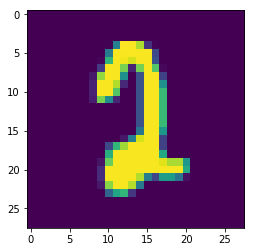

In [25]:
display(data_set[18][0])

In [26]:
def backdoor(bd_set_indices, verbose = False):
    (x_train, y_train), (x_test, y_test) = before() 
    DATA_SET_INDICES = random.sample(range(x_train.shape[0]), DATA_SET_SIZE)
    data_set = [x_train[i] for i in DATA_SET_INDICES]
    # Poisoning 
    for i in bd_set_indices: 
        poison_1(data_set[i], 27, 27)
        
    for idx ,img in enumerate(data_set): 
        y = np.argmax(models["p1"].predict(img.reshape(1,28,28,1)))
        data_set[idx] = (img, y)
        
    start = time.time()
    backdoor_predictions = find_backdoor_image(data_set, verbose)
    
    print(f"Time taken: {round(time.time() - start, 3)} s")
    custom_confusion_matrix_report(backdoor_predictions, bd_set_indices)

In [27]:
def main(): 
    print("Front")
    BACKDOOR_SET_INDICES_FRONT = random.sample(range(int(DATA_SET_SIZE/10)), BACKDOOR_SET_SIZE)
    print(BACKDOOR_SET_INDICES_FRONT)
    backdoor(BACKDOOR_SET_INDICES_FRONT)
    
    print("Middle")
    BACKDOOR_SET_INDICES_MIDDLE = random.sample(range(int(4 * DATA_SET_SIZE/10), int(6 * DATA_SET_SIZE/10)), BACKDOOR_SET_SIZE)
    print(BACKDOOR_SET_INDICES_MIDDLE)
    backdoor(BACKDOOR_SET_INDICES_MIDDLE)
    
    print("At the back")
    BACKDOOR_SET_INDICES_BACK = random.sample(range(int(9 * DATA_SET_SIZE/10), DATA_SET_SIZE), BACKDOOR_SET_SIZE)
    print(BACKDOOR_SET_INDICES_BACK)
    backdoor(BACKDOOR_SET_INDICES_BACK)

In [28]:
main()

Front
[2, 4, 6, 9, 1]


Mean timing: 0.3070499897003174
Max timing: 0.3070499897003174
Min timing: 0.3070499897003174



Time taken: 0.717 s
Predictions:  [11, 46, 56, 68]
Actual:  [2, 4, 6, 9, 1]
Accuracy: 0.95
True Positive Rate: 0.0
False Positive Rate: 0.042105263157894736
True Negative rate: 1.0
--------------------------
Middle
[57, 48, 55, 42, 43]


Mean timing: 0.20921080071350623
Max timing: 0.3912651538848877
Min timing: 0.06953191757202148


Time taken: 13.921 s
Predictions:  [11, 46, 56, 68]
Actual:  [57, 48, 55, 42, 43]
Accuracy: 0.95
True Positive Rate: 0.0
False Positive Rate: 0.042105263157894736
True Negative rate: 1.0
--------------------------
At the back
[92, 96, 90, 93, 94]


Mean timing: 0.20374518591207225
Max timing: 0.5318021774291992
Min timing: 0.026433229446411133


Time taken: 29.404 s
Predictions:  [56]
Actual:  [92, 96, 90, 93, 94]
Accuracy: 0.95
True Positive Rate: 0.0
False Positive Rate: 0.010526315789473684
True Negative rate: 1.0
--------------------------
